# Set environment

In [ ]:
# # http://pytorch.org/
# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [ ]:
# !git clone https://github.com/gilbertolem/ProgGen

In [ ]:
# from os import chdir, getcwd
# chdir("ProgGen")
# from sys import path
# path.append(getcwd())

# Train

In [2]:
import torch
import utils.data_tools as data_tools
from utils.nets import ProgGenRNN, WeightedLoss
from pickle import load
import matplotlib.pyplot as plt

xml_directory = "XML_Tunes/"
torch.manual_seed(999)
use_gpu = torch.cuda.is_available()
print("GPU available: {}".format(use_gpu))

GPU available: False


In [5]:
# Load vocabulary
words_text2num = load(open("maps/words_text2num.txt",'rb'))
vocab_size = len(words_text2num)

# Create training data
filter_names = ['Charlie Parker']
filter_fracs = [1.0]
filters = {'names':filter_names, 'frac':filter_fracs}
Train, Val = data_tools.musicxml2tensor(xml_directory, words_text2num, filters=filters)
train_data = data_tools.TuneData(Train)
val_data = data_tools.TuneData(Val)


CREATING TENSORS FROM MUSICXML FILES...


	297 tunes successfully loaded for training.
	75 tunes successfully loaded for validation.


In [6]:
# Construct Neural Net
embed_size = 100
hidden_size = 256
num_layers = 1
dropout = 0
bidirectional = True
rnn_type = 'lstm'
model = ProgGenRNN(rnn_type, vocab_size, embed_size, hidden_size, num_layers, dropout, bidirectional)
loss_fn = WeightedLoss()

# Define loader
sampler = torch.utils.data.RandomSampler(train_data)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 3000 if use_gpu else 512, sampler = sampler, num_workers = 1 if use_gpu else 4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 3000 if use_gpu else 512, num_workers = 1 if use_gpu else 4)

if use_gpu:
    model = model.cuda()
    loss_fn = loss_fn.cuda()

In [7]:
# Define loss function and optimizer
lr = 1e-2
optim = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
from utils.training import train
epochs = 5
losses = train(epochs, model, optim, train_loader, val_loader, loss_fn, use_gpu)


--------------------------------------------------------------------
TRAINING MODEL... 

   Epoch | Training Loss | Val. Loss


       0 |          3.14 |      2.87


       1 |          3.02 |      2.87


       2 |          2.99 |      2.76


       3 |          2.89 |      2.59


       4 |          2.76 |      2.46


       5 |          2.65 |      2.38


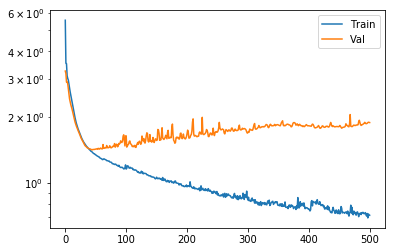

0.7090036869049072
1.8870422840118408
1.3828445672988892
1.4135241508483887


In [6]:
from numpy import argmin
print("Final Loss:\n\tTrain: {}\n\tVal: {}".format(losses[0][-1], losses[1][-1]))

idx = argmin(losses[1])
print("Final Loss:\n\tTrain: {}\n\tVal: {}".format(losses[0][idx], losses[1][idx]))

plt.semilogy(losses[0], label='Train')
plt.semilogy(losses[1], label='Val')
plt.legend()
plt.show()



# Generate something

In [10]:
from utils.generating import generate_progression

model_name = "model"
initial_chord = "4C_maj"
tune_len = 32
top = 10

prog = generate_progression(initial_chord, tune_len, top, model_name, verbose = False)
print("Generated Progression:\n")
print(prog)

Generated Progression:

Cmaj           |
